<a href="https://colab.research.google.com/github/DiNOV-Tokyo/yolov5/blob/main/DL_torchvsion_ResNet101_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.ResNet101でFineTuning学習・推論

参考にしたサイト# https://github.com/YutaroOgawa/pytorch_advanced/tree/master/1_image_classification



https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

## 1.1 Google Drive をマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks
#%mkdir yolo_train
%cd yolo_train

/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/yolo_train


## 1.2 モジュール読み込み

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import time

import numpy as np
from tqdm import tqdm
from PIL import Image
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch Version:  1.9.0+cu102
Torchvision Version:  0.10.0+cu102
Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [12]:
# transformsを定義
size = (224, 224)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)


## 1.3 データパス設定

In [13]:
# datasetsを定義
train_data_dir = 'dataset/train'
val_data_dir = 'dataset/val'

image_datasets = {
    'train': torchvision.datasets.ImageFolder(train_data_dir, transform=data_transforms['train']),
    'val': torchvision.datasets.ImageFolder(val_data_dir, transform=data_transforms['val'])
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=10, shuffle=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=5)
}

dataset_sizes = {
    'train': len(image_datasets['train']),
    'val': len(image_datasets['val'])
}

class_names = image_datasets['train'].classes
print('分類種類:', class_names)

分類種類: ['aoi-shrine', 'gym', 'monument', 'pump', 'shrine', 'stone', 'temple']


## 1.4 モデル作成・設定　ResNet101

In [14]:
# GPU/CPUが使えるかどうか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 学習した結果のモデル（保存名）
best_model_name = "best_model_resnet101_sgd_ft.pth"
model_ft_name = best_model_name

In [15]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [16]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [17]:
model_name = "resnet"
num_classes = len(class_names)

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

## 1.5 最適化手法を設定

In [18]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# https://rightcode.co.jp/blog/information-technology/torch-optim-optimizer-compare-and-verify-update-process-and-performance-of-optimization-methods
lr=0.0001
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
#optimizer_ft = optim.Adam(params_to_update, lr=0.0001,)
#optimizer_ft = optim.Adagrad(params, lr)
#optimizer_ft = optim.RMSprop(params, lr)
#optimizer_ft = optim.Adadelta(params, lr)
#optimizer_ft = optim.AdamW(params, lr)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

## 1.6 学習関数設定

In [19]:
# 学習処理
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    """
    model:学習モデル
    dataloader:学習、評価データのdataloader
    optimizer:最適化関数
    crierion:ロス関数
    num_epochs:学習回数
    device:CPUかGPUか
    """
    since = time.time()
    
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # 学習を繰り返す
    for epoch in range(num_epochs):
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print('-' * 10)

        # trainとvalを繰り返す
        for phase in ['train', 'val']:
            # モデルを学習モードか評価モードに切り替える
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            # 精度計算用
            loss_sum = 0.0
            acc_sum = 0.0
            total = 0

            # 進捗の表示
            with tqdm(total=len(dataloaders[phase]),unit="batch") as pbar:
                pbar.set_description(f"Epoch[{epoch}/{num_epochs}]({phase})")
                
                # dataloadersからバッチサイズに応じてデータを取得
                for inputs, labels in dataloaders[phase]:
                    # 画像とラベルをGPU/CPUか切り替え
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        # Special case for inception because in training it has an auxiliary output. In train
                        #   mode we calculate the loss by summing the final output and the auxiliary output
                        #   but in testing we only consider the final output.
                        if is_inception and phase == 'train':
                            # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                            # 予測
                            outputs, aux_outputs = model(inputs)
                            # ロス算出
                            loss1 = criterion(outputs, labels)
                            loss2 = criterion(aux_outputs, labels)
                            loss = loss1 + 0.4*loss2
                        else:
                            # 予測
                            outputs = model(inputs)
                            # ロス算出
                            loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # ロス、精度を算出
                    total += inputs.size(0)
                    loss_sum += loss.item() * inputs.size(0)
                    acc_sum += torch.sum(preds == labels.data).item()
                    
                    # 進捗の表示
                    pbar.set_postfix({"loss":loss_sum/float(total),"accuracy":float(acc_sum)/float(total)})
                    pbar.update(1)

            # 1エポックでのロス、精度を算出
            epoch_loss = loss_sum / dataset_sizes[phase]
            epoch_acc = acc_sum / dataset_sizes[phase]
            
            # 一番良い制度の時にモデルデータを保存
            if phase == 'val' and epoch_acc > best_acc:
                print(f"save model epoch:{epoch} loss:{epoch_loss} acc:{epoch_acc}")
                torch.save(model, best_model_name)
                best_acc = epoch_acc

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model = torch.load(best_model_name)
    return model, val_acc_history


## 1.7 学習

In [20]:
# 関数を実行
##num_epochs = 10
num_epochs = 4

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch[0/4](train):   0%|          | 0/56 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch[0/4](val): 100%|██████████| 28/28 [00:43<00:00,  1.55s/batch, loss=0.0484, accuracy=1]


save model epoch:0 loss:0.048429542287651985 acc:1.0


Epoch[3/4](val): 100%|██████████| 28/28 [00:02<00:00, 12.11batch/s, loss=0.0063, accuracy=1]


Training complete in 4m 47s
Best val Acc: 1.000000


## 1.8 推論

torch.Size([7])
[0.0056714  0.00256856 0.00216776 0.01153803 0.00237898 0.9710576
 0.00461761]
stone


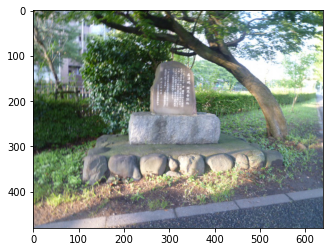

In [24]:
# テストデータで確認
# 今回学習したモデルでテスト
model_ft = torch.load(model_ft_name)

# 対象画像
#filename = 'dataset/test.jpg'  #gym
#filename = 'dataset/test2.JPG'  #temple
#filename = 'dataset/monument.JPG' #monument
#filename = 'dataset/shrine.JPG' #shrine
#filename = 'dataset/aoi-shrine.JPG' #aoi-shrine
#filename = 'dataset/pump.JPG' #pump
filename = 'dataset/stone.JPG' #stone

# 読み込み画像をリサイズやtensorなどの方に変換
input_image = Image.open(filename)

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

# GPU使える場合はGPUを使う
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model_ft.to('cuda')

# AIの判定
with torch.no_grad():
    output = model_ft(input_batch)
output = torch.nn.functional.softmax(output[0], dim=0)
print(output.shape)

# 出力結果から2種類のうちどれかを数値で取得
output = output.to('cpu').detach().numpy().copy()
ind = np.argmax(output)
print(output)
print(class_names[ind])

%matplotlib inline
 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(filename),cmap="gray")